In [2]:
%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import BaseDataProvider, RandomDataProvider
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

Note:

The current version of Qiskit Finance has not been updated to account for the changes in yfiance.  I've copied their code and
made the changes required to make it work.


In [4]:
# This code is part of a Qiskit project.
#
# (C) Copyright IBM 2020, 2024.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

""" Yahoo data provider. """

from __future__ import annotations
import datetime
import logging
import tempfile
import yfinance as yf

logger = logging.getLogger(__name__)

# Sets Y!Finance cache path in a new temp folder.
# This is done to avoid race conditions in the same cache file
# from different processes.
# The path will be automatically deleted if this module unloads cleanly.
# This needs to be done during yfinance initialization before any call
_temp_dir = tempfile.TemporaryDirectory()  # pylint: disable=consider-using-with
yf.set_tz_cache_location(_temp_dir.name)


class YahooDataProvider(BaseDataProvider):
    """Yahoo data provider.

    This data provider retrieves stock market data from Yahoo Finance using the yfinance library.
    For more details on usage, please refer to the official documentation:
    https://qiskit-community.github.io/qiskit-finance/tutorials/11_time_series.html
    """

    def __init__(
        self,
        tickers: str | list[str] | None = None,
        start: datetime.datetime = datetime.datetime(2016, 1, 1),
        end: datetime.datetime = datetime.datetime(2016, 1, 30),
    ) -> None:
        """
        Initialize the Yahoo Data Provider.

        Args:
            tickers (str | list[str] | None): Tickers for the data provider.

                * If a string is provided, it can be a single ticker symbol or multiple symbols
                  separated by semicolons or newlines.
                * If a list of strings is provided, each string should be a single ticker symbol.

                Default is :code:`None`, which corresponds to no tickers provided.
            start (datetime.datetime): Start date of the data.
                Default is January 1st, 2016.
            end (datetime.datetime): End date of the data.
                Default is January 30th, 2016.
        """
        super().__init__()

        if tickers is None:
            tickers = []
        if isinstance(tickers, str):
            tickers = tickers.replace("\n", ";").split(";")

        self._tickers = tickers
        self._n = len(tickers)
        self._start = start.strftime("%Y-%m-%d")
        self._end = end.strftime("%Y-%m-%d")
        self._data = []

    def run(self) -> None:
        """
        Loads data from Yahoo Finance.

        This method retrieves stock market data from Yahoo Finance using the :code:`yfinance` library,
        and populates the data attribute of the base class, enabling further calculations like
        similarity and covariance matrices.

        Raises:
            QiskitFinanceError: If there are missing tickers in download,
                if accessing Yahoo Data fails, or if no data is found for
                the specified date range, possibly due to de-listed symbols.
        """
        if len(self._tickers) == 0:
            raise QiskitFinanceError("Missing tickers to download.")
        self._data = []
        stocks_notfound = []
        try:
            # Download multiple tickers in single thread to avoid
            # race condition
            stock_data = yf.download(
                self._tickers,
                start=self._start,
                end=self._end,
                group_by="ticker",
                threads=False,
                progress=logger.isEnabledFor(logging.DEBUG),
            )
            
            if len(self._tickers) == 1:
                ticker_name = self._tickers[0]
                stock_value = stock_data["Close"]

                if stock_value.dropna().empty:
                    stocks_notfound.append(ticker_name)

                self._data.append(stock_value)

            else:
                for ticker_name in self._tickers:
                    stock_value = stock_data[ticker_name]["Close"]

                    if stock_value.dropna().empty:
                        stocks_notfound.append(ticker_name)

                    self._data.append(stock_value)

        except Exception as ex:  # pylint: disable=broad-except
            logger.debug(ex, exc_info=True)
            raise QiskitFinanceError("Accessing Yahoo Data failed.") from ex

        if stocks_notfound:
            raise QiskitFinanceError(
                f"No data found for this date range, symbols may be de-listed: {stocks_notfound}."
            )


In [6]:
data = RandomDataProvider(
    tickers=["TICKER1", "TICKER2"],
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=1,
)
data.run()

Means:
[33.97683271 97.61130683]
A time-series similarity measure:
[[1.00000000e+00 5.41888011e-04]
 [5.41888011e-04 1.00000000e+00]]


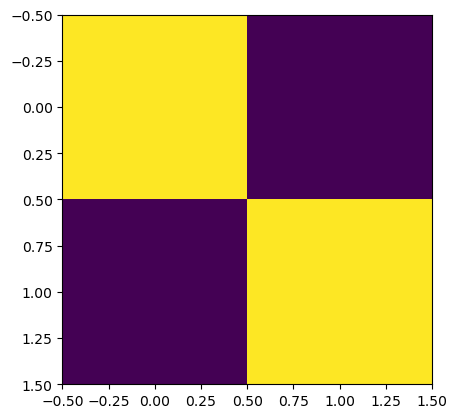

A covariance matrix:
[[2.08413157 0.20842107]
 [0.20842107 1.99542187]]


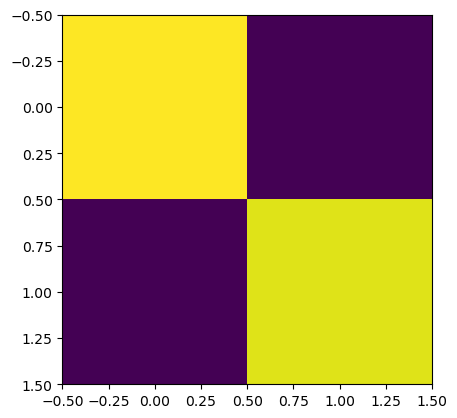

In [7]:
means = data.get_mean_vector()
print("Means:")
print(means)

rho = data.get_similarity_matrix()
print("A time-series similarity measure:")
print(rho)
plt.imshow(rho)
plt.show()

cov = data.get_covariance_matrix()
print("A covariance matrix:")
print(cov)
plt.imshow(cov)
plt.show()

The underlying evolution of stock prices:


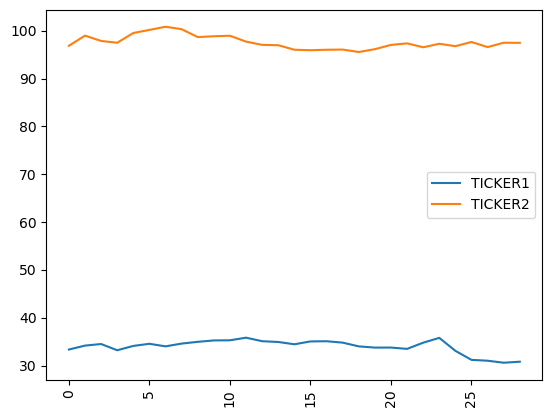

In [8]:
print("The underlying evolution of stock prices:")
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()

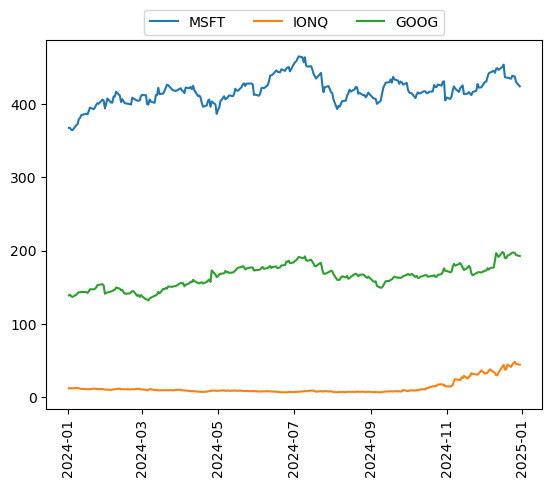

In [9]:
try:
    data = YahooDataProvider(
        tickers=["MSFT", "IONQ", "GOOG"],
        start=datetime.datetime(2024, 1, 1),
        end=datetime.datetime(2024, 12, 31),
    )
    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex:
    data = None
    print(ex)

Means:
[417.8965183   12.82083668 164.59162897]
A time-series similarity measure:
[[1.00000000e+00 9.83535652e-06 1.57283334e-05]
 [9.83535652e-06 1.00000000e+00 2.62505301e-05]
 [1.57283334e-05 2.62505301e-05 1.00000000e+00]]


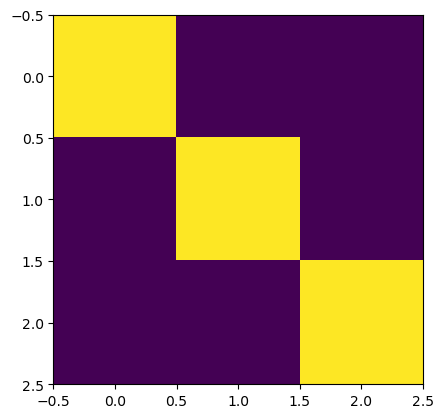

A covariance matrix:
[[329.84794438  39.07220425 208.44282314]
 [ 39.07220425  84.79277283  59.30374607]
 [208.44282314  59.30374607 239.78113464]]


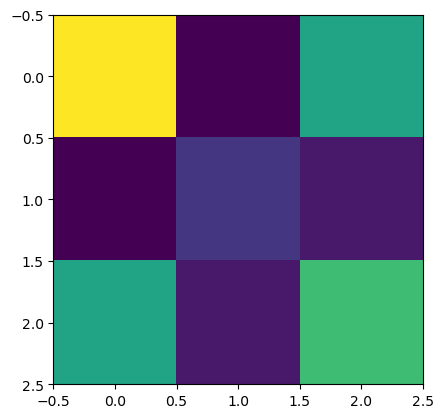

In [11]:
means = data.get_mean_vector()
print("Means:")
print(means)

rho = data.get_similarity_matrix()
print("A time-series similarity measure:")
print(rho)
plt.imshow(rho)
plt.show()

cov = data.get_covariance_matrix()
print("A covariance matrix:")
print(cov)
plt.imshow(cov)
plt.show()

In [29]:
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.result import QuasiDistribution
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [15]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

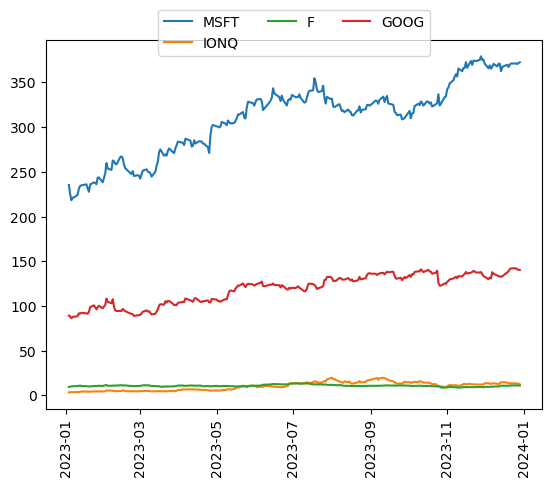

In [16]:
try:
    data = YahooDataProvider(
        tickers=["MSFT", "IONQ", "F", "GOOG"],
        start=datetime.datetime(2023, 1, 1),
        end=datetime.datetime(2023, 12, 31),
    )
    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex:
    data = None
    print(ex)
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

[0.00197166 0.00678877 0.00082186 0.00200177]


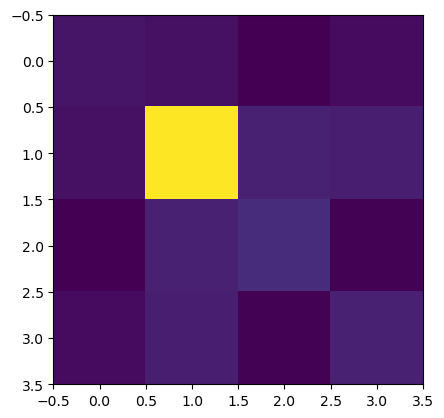

In [17]:
print(mu)
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [18]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00012520473499030233*x_0^2 + 0.00021492908482971..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [21]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [24]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 1. 0. 0.], value -0.0067

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 1 0 0]	-0.0067		1.0000


In [30]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

Optimal: selection [1. 1. 0. 0.], value -0.0067

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0035		0.7568
 [0 1 1 0]	-0.0053		0.0859
 [0 1 0 1]	-0.0066		0.0762
 [0 0 1 1]	-0.0023		0.0166
 [0 0 1 0]	-0.0006		0.0156
 [0 0 0 1]	-0.0018		0.0107
 [1 1 0 1]	-0.0080		0.0098
 [1 1 1 1]	-0.0081		0.0088
 [0 1 1 1]	-0.0067		0.0059
 [1 0 1 1]	-0.0039		0.0059
 [1 1 1 0]	-0.0069		0.0039
 [0 0 0 0]	0.0000		0.0020
 [0 1 0 0]	-0.0051		0.0010
 [1 1 0 0]	-0.0067		0.0010


In [31]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 1. 0. 0.], value -0.0067

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 1 0 0]	-0.0067		0.1885
 [0 0 1 1]	-0.0023		0.1777
 [0 1 0 1]	-0.0066		0.1680
 [0 1 1 0]	-0.0053		0.1650
 [1 0 1 0]	-0.0024		0.1533
 [1 0 0 1]	-0.0035		0.1436
 [1 1 1 1]	-0.0081		0.0029
 [1 0 0 0]	-0.0018		0.0010


In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

In [2]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:9: SyntaxWarning: invalid escape sequence '\%'
C:\Users\markw\AppData\Local\Temp\ipykernel_64296\2885665035.py:8: SyntaxWarning: invalid escape sequence '\$'
  plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
C:\Users\markw\AppData\Local\Temp\ipykernel_64296\2885665035.py:9: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel("Probability ($\%$)", size=15)


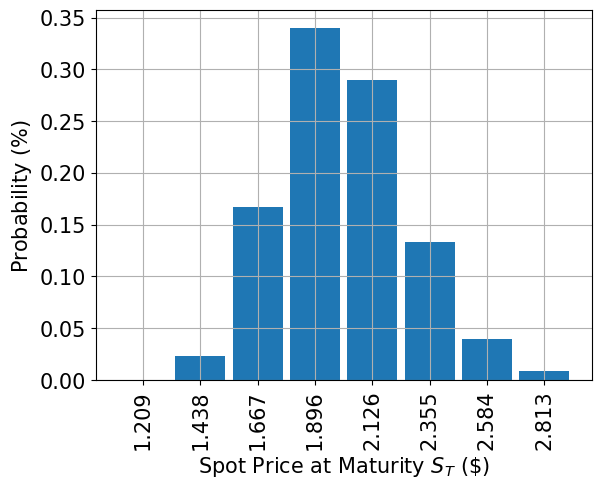

In [3]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

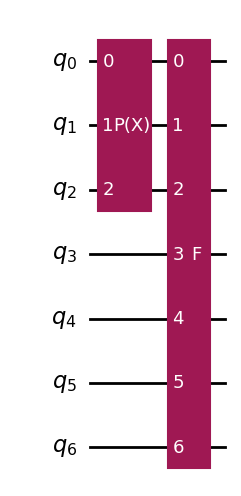

In [4]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective function
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw('mpl')

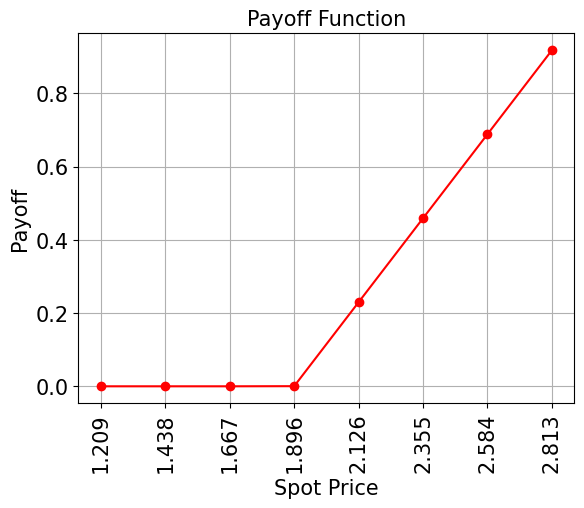

In [5]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [6]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.1623
exact delta value:   	0.8098


In [7]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [8]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(options={"shots": 100, "seed": 75})
)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

C:\Users\markw\AppData\Local\Temp\ipykernel_64296\1826711760.py:8: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  epsilon_target=epsilon, alpha=alpha, sampler=Sampler(options={"shots": 100, "seed": 75})


Exact value:        	0.1623
Estimated value:    	0.1675
Confidence interval:	[0.1611, 0.1738]


In [10]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(options={"shots": 100, "seed": 75})
)

C:\Users\markw\AppData\Local\Temp\ipykernel_64296\922374745.py:12: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  epsilon_target=epsilon, alpha=alpha, sampler=Sampler(options={"shots": 100, "seed": 75})


In [11]:
result = ae.estimate(problem)

In [12]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1675
Confidence interval:	[0.1611, 0.1738]


In [2]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 7

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:9: SyntaxWarning: invalid escape sequence '\%'
C:\Users\markw\AppData\Local\Temp\ipykernel_35860\2885665035.py:8: SyntaxWarning: invalid escape sequence '\$'
  plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
C:\Users\markw\AppData\Local\Temp\ipykernel_35860\2885665035.py:9: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel("Probability ($\%$)", size=15)


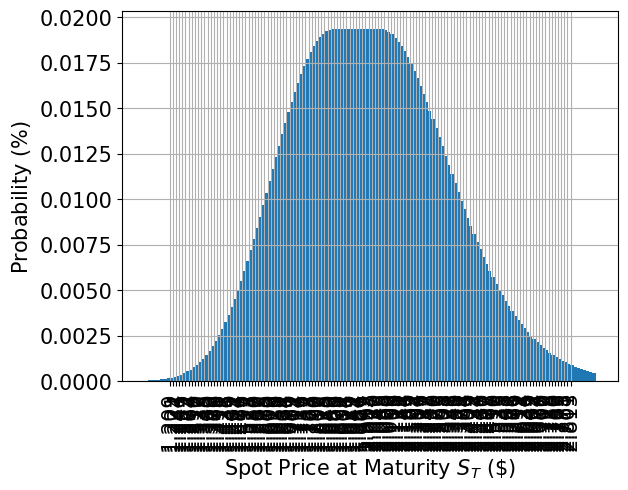

In [3]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

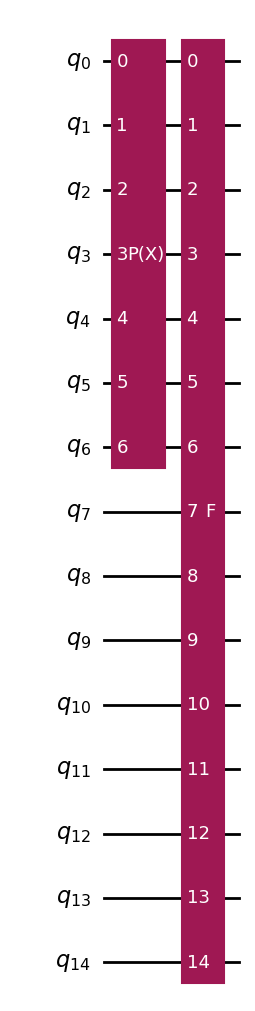

In [4]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective function
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw('mpl')

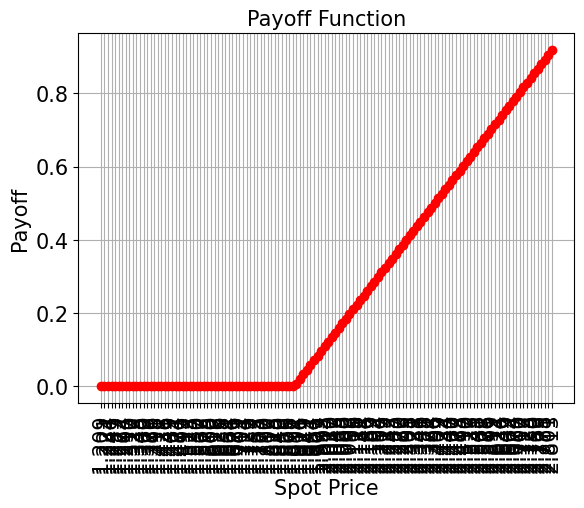

In [5]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [6]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.1668
exact delta value:   	0.6441


In [9]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[7],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(options={"shots": 100, "seed": 75})
)

C:\Users\markw\AppData\Local\Temp\ipykernel_35860\392720839.py:11: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  epsilon_target=epsilon, alpha=alpha, sampler=Sampler(options={"shots": 100, "seed": 75})


In [10]:
result = ae.estimate(problem)
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1668
Estimated value:    	0.1713
Confidence interval:	[0.1654, 0.1773]
